In [6]:
#importing the require libraries
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import cv2

In [7]:
# Load metadata
metadata = pd.read_csv('metadata.csv')
class_dict = pd.read_csv('class_dict.csv')

In [8]:
metadata.head()

image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png

In [9]:
metadata.split.unique()

array(['train', 'valid', 'test'], dtype=object)

In [10]:
metadata.shape

(8570, 4)

In [11]:
class_dict

name    r    g    b
0        road  255  255  255
1  background    0    0    0

In [12]:
#Preprocessing the images
'''
In this step, we define a function binarize_mask that processes the mask images to ensure they have binary values (0 and 255). 
This is necessary because the mask images might have pixel values other than 0 and 255, and we want to standardize them.

cv2.threshold function: This function applies a fixed-level threshold to an array. 
In our case, if the pixel value is greater than 128, it is set to 255 (white), and if it is less than or equal to 128, it is set to 0 (black).
'''
#Since our masks need binarization, we'll define a function for that
def binarize_mask(mask):
    _, binarized = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    return binarized

metadata_train = metadata[metadata['split'] == 'train']

# Rezise the images to 256, 256
img_size = (256, 256)

# Initialize lists to store images and masks
images = []
masks = []

# Process all images and masks
for idx, row in metadata_train.iterrows():
    img = cv2.imread(row['sat_image_path'])
    img = cv2.resize(img, img_size)
    mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
    mask = binarize_mask(mask)
    mask = cv2.resize(mask, img_size)
    mask = np.expand_dims(mask, axis=-1)
    
    images.append(img)
    masks.append(mask)

# Convert lists to numpy arrays
images = np.array(images) / 255.0  # Normalize images
masks = np.array(masks) / 255.0    # Normalize masks

print(f"Processed {len(images)} images and {len(masks)} masks.")

Processed 6226 images and 6226 masks.


In [13]:
# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.25, random_state=42)

print(f"Training set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")

Training set size: 4669 images
Validation set size: 1557 images


In [14]:
type(train_images)

numpy.ndarray

I had to stop training here because my laptop didn't have enough resources to run it efficiently and my CPU would have died. I switched to Google Colab, but even there the session would restart due to resource constraints.

Hence save the preprocessed train-test split array into a compressed numpy object. and transnferred it to my office's computer. Apparently, my office's Linux machine with 32 gigs of RAM worked just fine. So the training script file is there separately named "TRAIN_PART.py". Best use of office resources, haha! (Just kidding)

In [27]:
np.savez('training_data_arrays.npz', train_images=train_images, val_images=val_images, train_masks=train_masks, val_masks=val_masks)

In [16]:
#Creating a data generator for training and validation sets since we have low resource device
'''
Given the large dataset and limited system resources, we use a data generator to load and preprocess images and masks in batches rather than 
loading the entire dataset into memory at once. This helps in managing memory usage efficiently.
'''
def data_generator(images, masks, batch_size):
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset + batch_size]
            batch_masks = masks[offset:offset + batch_size]
            yield batch_images, batch_masks


#defining the U-Net Model
def unet_model(input_size):
    inputs = Input(input_size)
    #Downsampling
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    #Upsampling
    up6 = concatenate([Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [17]:
# Parameters
batch_size = 10
input_size = (img_size[0], img_size[1], 3)

# Create the model
model = unet_model(input_size)

# Create data generators
train_gen = data_generator(train_images, train_masks, batch_size)
val_gen = data_generator(val_images, val_masks, batch_size)

# Calculate steps per epoch
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(val_images) // batch_size

# Ensure that the last incomplete batch is processed
if len(train_images) % batch_size != 0:
    steps_per_epoch += 1
if len(val_images) % batch_size != 0:
    validation_steps += 1

In [35]:
# Define EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_unet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    epochs=10,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/10
128/467 ━━━━━━━━━━━━━━━━━━━━ 28:00 5s/step - accuracy: 0.9119 - loss: 0.3765

KeyboardInterrupt: 

Saved the model in the office machine after training. Then used it here.

In [30]:
# Load the best model
model.load_weights('best_unet_model.h5')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_gen, steps=validation_steps)

# Print the evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9634 - loss: 0.0919
Validation Loss: 0.09357567876577377
Validation Accuracy: 0.9628781080245972


The below code has been executed as part of TRAIN_PART.py

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step
Validation Precision: 0.7965562080579894
Validation Recall: 0.33390354141095896
Validation F1-Score: 0.47055711435704345


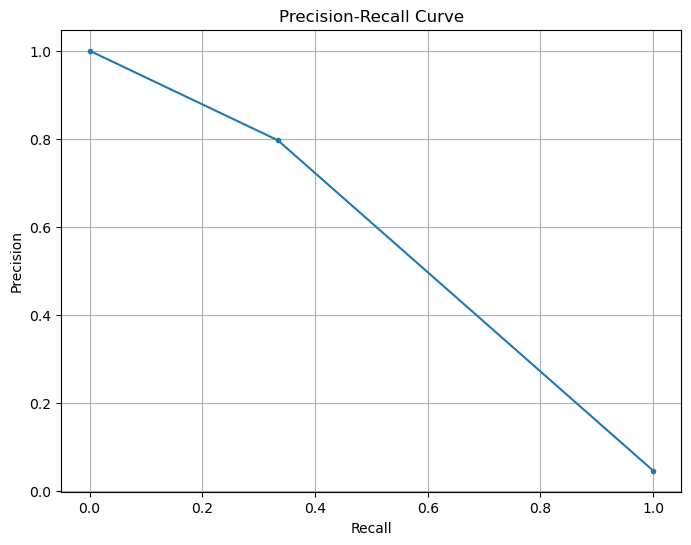

In [43]:
# Additional Metrics
from sklearn.metrics import precision_recall_curve

def evaluate_model(model, images, masks, batch_size):
    preds = model.predict(images, batch_size=batch_size)
    preds = (preds > 0.5).astype(np.uint8)  # Binarize predictions
    # Ensure masks are binary
    masks = (masks > 0.5).astype(np.uint8)
    
    # Flatten the arrays for metric calculations
    flat_preds = preds.flatten()
    flat_masks = masks.flatten()

    precision = precision_score(flat_masks, flat_preds)
    recall = recall_score(flat_masks, flat_preds)
    f1 = f1_score(flat_masks, flat_preds)

    print(f"Validation Precision: {precision}")
    print(f"Validation Recall: {recall}")
    print(f"Validation F1-Score: {f1}")
    
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(flat_masks, flat_preds)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

# Evaluate the model on the validation set
evaluate_model(model, val_images, val_masks, batch_size)

We can infer from the graph:
- **High Precision and Recall Values:** The curve reaches close to 1.0 on both the precision and recall axes, indicating the model can accurately identify a large portion of the relevant pixels (high precision) and captures most of the actual relevant pixels (high recall).
- **Steep Curve:** The curve rises quickly at the beginning, suggesting a significant increase in precision and recall with a relatively small change in the classification threshold. This is a desirable characteristic.

Based on the F1 score of 0.47, the U-Net model's performance is likely low and could benefit from further improvement. This can be achieved by proper preprocessing, hyperparameter tuning and data augmentation. Which might be considered as future scope for this task

In [47]:
#PREDICTING MASKS FOR TEST SET
img_size = (256, 256)  # Model input size
original_size = (1024, 1024)  # Original image size

def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def postprocess_mask(mask, original_size):
    mask = cv2.resize(mask, original_size)
    mask = (mask > 0.5).astype(np.uint8) * 255  # Binarize the mask
    return mask
    
def display_image_and_mask(image_path, mask):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


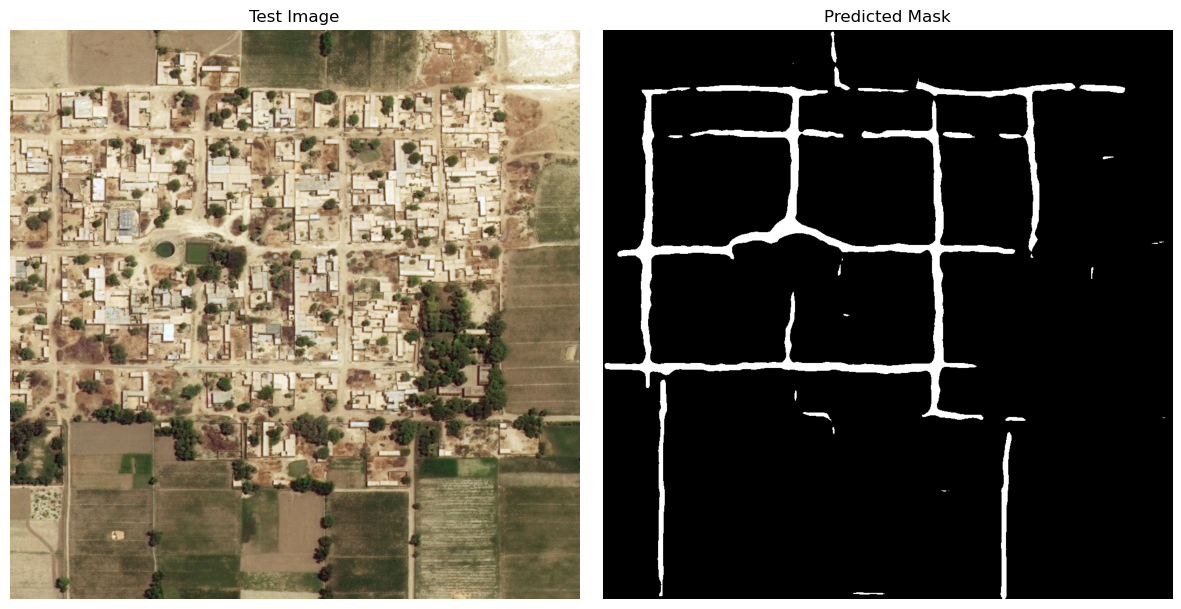

In [49]:
test_image_path = metadata[metadata['split'] == 'test']['sat_image_path'].iloc[0]
img = preprocess_image(test_image_path, img_size)
pred_mask = model.predict(img)[0]
pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove channel dimension
pred_mask = postprocess_mask(pred_mask, original_size)
display_image_and_mask(test_image_path, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


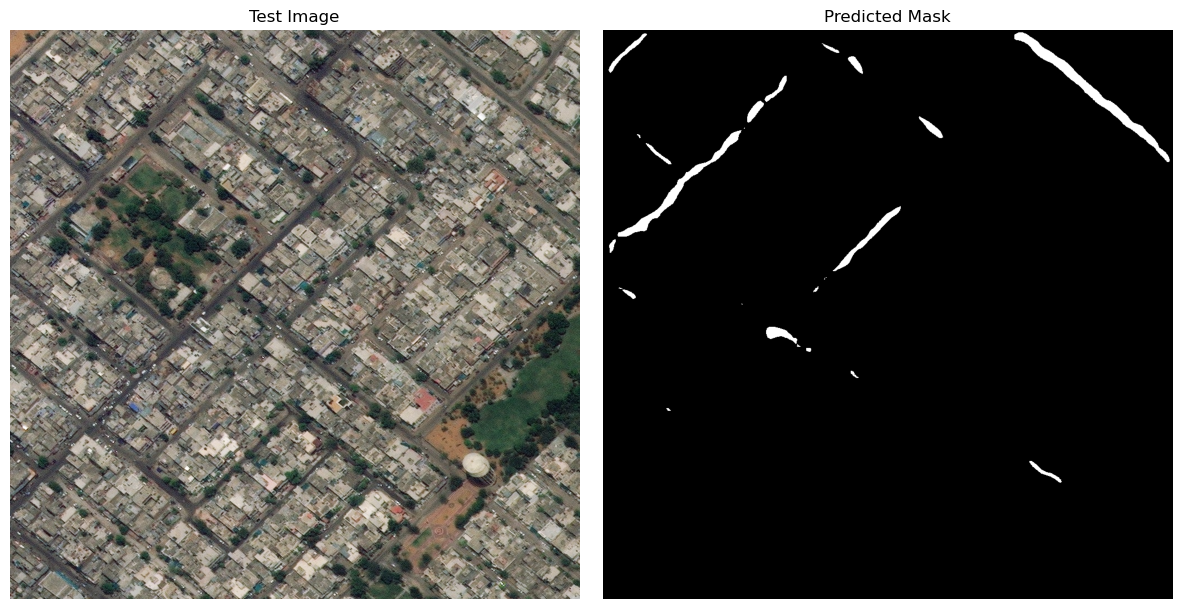

In [51]:
test_image_path = metadata[metadata['split'] == 'test']['sat_image_path'].iloc[10]
img = preprocess_image(test_image_path, img_size)
pred_mask = model.predict(img)[0]
pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove channel dimension
pred_mask = postprocess_mask(pred_mask, original_size)
display_image_and_mask(test_image_path, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


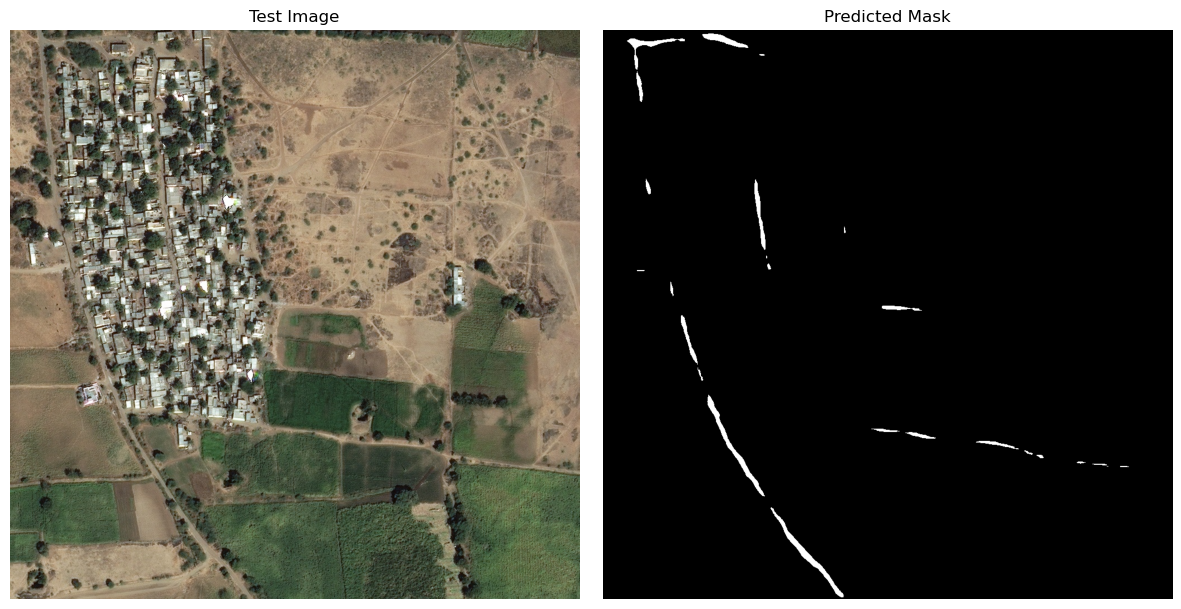

In [53]:
test_image_path = metadata[metadata['split'] == 'test']['sat_image_path'].iloc[5]
img = preprocess_image(test_image_path, img_size)
pred_mask = model.predict(img)[0]
pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove channel dimension
pred_mask = postprocess_mask(pred_mask, original_size)
display_image_and_mask(test_image_path, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


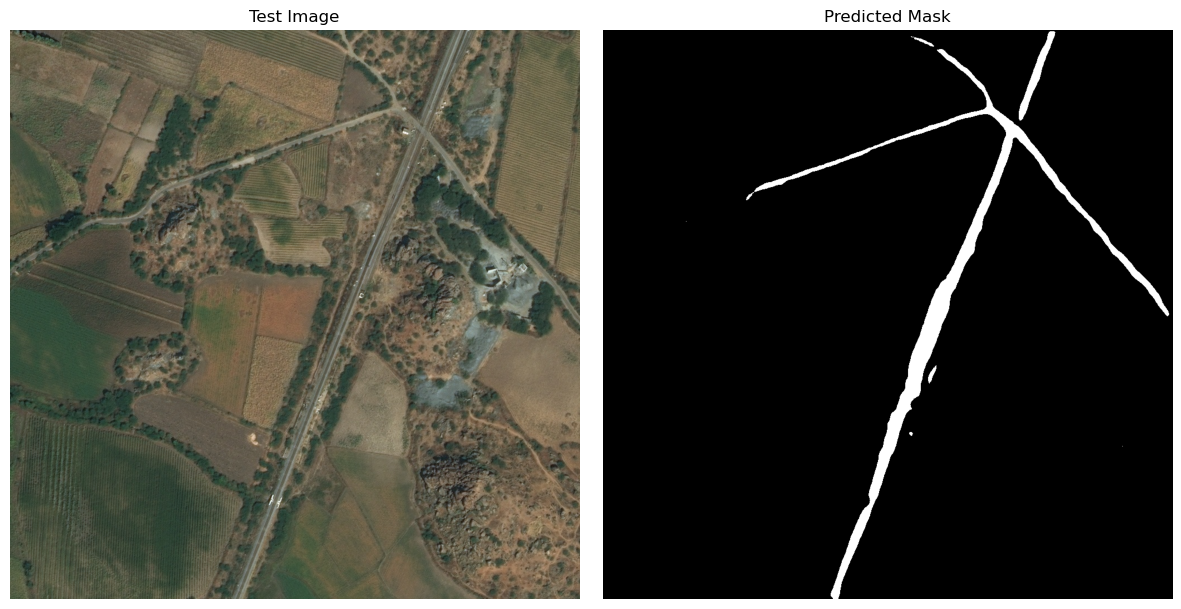

In [55]:
test_image_path = metadata[metadata['split'] == 'test']['sat_image_path'].iloc[19]
img = preprocess_image(test_image_path, img_size)
pred_mask = model.predict(img)[0]
pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove channel dimension
pred_mask = postprocess_mask(pred_mask, original_size)
display_image_and_mask(test_image_path, pred_mask)

## CONCLUSION
- From above results it is clear that the model is able to extract the road network.
- Although it is not able to detect roads where there is dense vegetation or buildings.
- Following might be the causes:
    - We have resized the image to (256, 256) before training. And this might be causing a loss of features.
    - The hyperparameter might require tuning to get optimal results.
    - The layers of the U-Net model might need a reconfiguration as they might not be contributing in learning all the features.